<a href="https://colab.research.google.com/github/mkhalil7625/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/Copy_of_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
# split train into train abnd val
from sklearn.model_selection import train_test_split
train,val = train_test_split(train, test_size=.2, stratify=train['status_group'],random_state=42)
train.shape,val.shape,test.shape

((47520, 41), (11880, 41), (14358, 40))

In [4]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates =['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [5]:
target = 'status_group'
features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test= test[features]

In [6]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(random_state=42,min_samples_leaf=5)
)

param_distributions = {
    # 'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__n_estimators': randint(50, 200), 
    # 'randomforestclassifier__max_depth': [40, None], 
    'randomforestclassifier__max_features': randint(7, 10),
    # 'randomforestclassifier__criterion': ["gini", "entropy"],
    # 'randomforestclassifier__min_samples_leaf':[1,2]
}
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    # cv=5, 
    n_iter=3,
    scoring='accuracy',
    verbose=60, 
    return_train_score=True,
    random_state = 42,
    n_jobs=-1,
    # pre_dispatch=4
    
)
search.fit(X_train, y_train);
# Fit on train, score on val
# pipeline.fit(X_train, y_train)
# print('Validation Accuracy', pipeline.score(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  13 out of  15 | elapsed:  3.0min remaining:   27.6s
[Parallel(n_jobs=-1)]: Done  15 out of 

In [7]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation Accuracy', search.best_score_)
# Best hyperparameters {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 8, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__n_estimators': 222, 'simpleimputer__strategy': 'mean'}


Best hyperparameters {'randomforestclassifier__max_features': 9, 'randomforestclassifier__n_estimators': 156}
Cross-validation Accuracy 0.8025252525252526


In [8]:
X_test = test[features]
y_pred = search.predict(X_test)

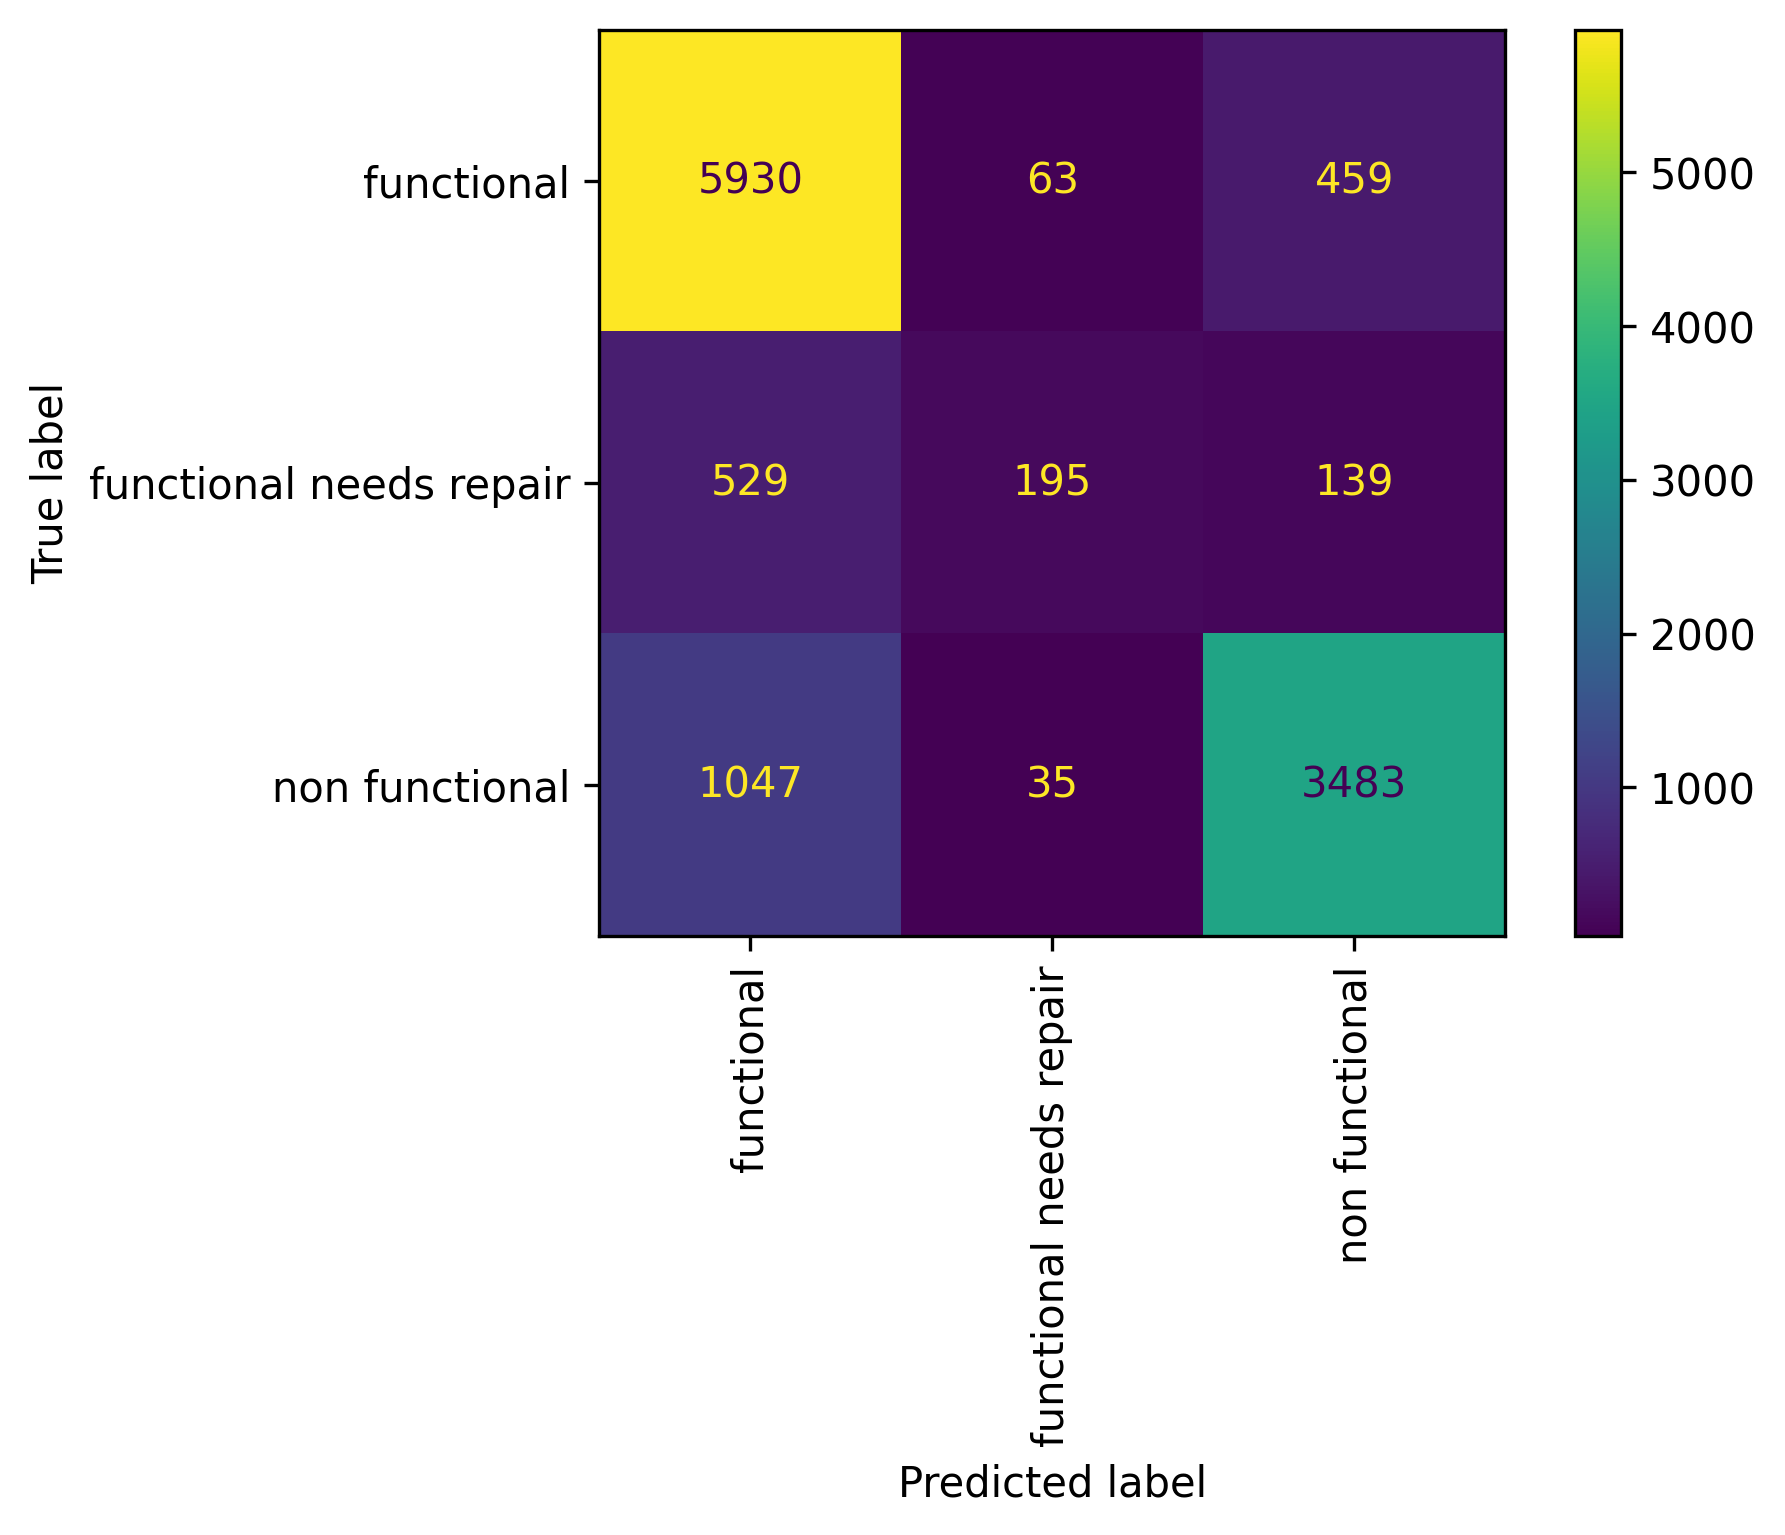

In [12]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 300
plot_confusion_matrix(search, X_val, y_val, values_format='.0f', xticks_rotation='vertical');


In [ ]:
submission = sample_submission.copy()
submission['status_group'] = y_pred #<--This is for your test data-->
submission.to_csv("Your_Submission.csv", index = False)